In [1]:
#If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

#Intro to pzflow

#This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some 2-D data.#

#You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

#    Eric Jang's tutorial: part 1, part 2
#    Here is a comprehensive list of papers, blogs, videos, and packages
#    Two good intro papers using Coupling Layers: NICE, Real NVP
#    The paper on Neural Spline Couplings

import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import timeit
import numpy as onp

In [2]:
cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")

In [3]:
quantities = ['redshift', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 
     'morphology/totalEllipticity', 'stellar_mass', 'totalStarFormationRate']
filters=['redshift<1', 'Mag_true_r_sdss_z0<-14.5']

In [4]:
gal = cosmo.get_quantities(quantities, filters)

In [6]:
data_unscaled = {}
data_unscaled['logSFRtot'] = np.log10(gal['totalStarFormationRate'])
data_unscaled['redshift']  = gal['redshift']
data_unscaled['logmass'] = np.log10(gal['stellar_mass'])
data_unscaled['Mag_true_g_sdss_z0']  = gal['Mag_true_g_sdss_z0']
data_unscaled['Mag_true_r_sdss_z0']  = gal['Mag_true_r_sdss_z0']
data_unscaled['Mag_true_i_sdss_z0']  = gal['Mag_true_i_sdss_z0']
data_unscaled['Mag_true_z_sdss_z0']  = gal['Mag_true_z_sdss_z0']
data_unscaled['morphology/totalEllipticity'] = gal['morphology/totalEllipticity']

In [7]:
data_unscaled = pd.DataFrame(data_unscaled)

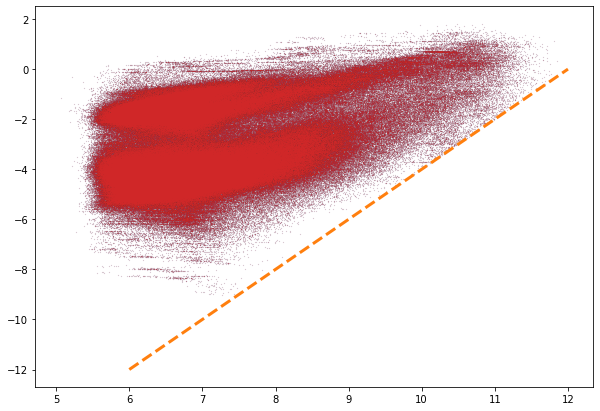

In [8]:
def f(logmass):
    return 2*logmass - 24

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_unscaled = data_unscaled[onp.asarray((data_unscaled['logSFRtot'] - 9) > f(data_unscaled['logmass']))]
x = np.linspace(6,12)
plt.figure(figsize=(10,7))
plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', ms=0.1, alpha=0.6)
plt.plot(data_unscaled['logmass'].values[::30],data_unscaled['logSFRtot'].values[::30]-9,'o', c='tab:red', ms=0.1, alpha=0.6)
plt.plot(x, f(x), ls='--', lw=3)

In [9]:
data_unscaled['g-r'] = data_unscaled['Mag_true_g_sdss_z0'] - data_unscaled['Mag_true_r_sdss_z0']
data_unscaled['r-i'] = data_unscaled['Mag_true_r_sdss_z0'] - data_unscaled['Mag_true_i_sdss_z0']
data_unscaled['i-z'] = data_unscaled['Mag_true_i_sdss_z0'] - data_unscaled['Mag_true_z_sdss_z0']


In [10]:
# standard scale the reference magnitude and colors
data = data_unscaled.copy()
for quality in ['logmass', 'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0', 'Mag_true_z_sdss_z0', 'g-r', 'r-i', 'i-z']:
    data[quality] = (data_unscaled[quality]-data_unscaled[quality].mean())/data_unscaled[quality].std()

In [11]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


#split into 10 chunks
data_list = split_dataframe(data, chunk_size=int(len(data)/1.e2))

data_subset = data.sample(n=int(len(data)/1.e2))



In [12]:
data_subset.head()


logSFRtot  redshift   logmass  Mag_true_g_sdss_z0  \
11961192   5.881627  0.991109  0.830928           -1.284813   
11940193   4.972474  0.986827 -1.458337            0.984752   
15682808   4.467297  0.613612 -0.592765            1.060176   
20653918   4.747582  0.368138 -0.125014            1.072816   
18850404   4.673808  0.290288  0.803643           -0.070784   

          Mag_true_r_sdss_z0  Mag_true_i_sdss_z0  Mag_true_z_sdss_z0  \
11961192           -1.209388           -1.162028           -1.118919   
11940193            1.144353            1.199766            1.216508   
15682808            1.088672            1.077645            1.067528   
20653918            1.099562            1.108885            1.113198   
18850404           -0.104520           -0.115319           -0.111115   

          morphology/totalEllipticity       g-r       r-i       i-z  
11961192                     0.215404 -0.358126 -0.432379 -0.391666  
11940193                     0.238538 -1.399896 -1.251339 -0.863011  
15682808                     0.143385 -0.403350 -0.134544 -0.254893  
20653918                     0.322887 -0.392068 -0.474815 -0.566792  
18850404                     0.219561  0.271985  0.209217 -0.037550

In [13]:
conditional_columns = data_subset.columns.drop(['redshift', 'logSFRtot'])
latent = Joint(Uniform((-3,3)), Normal(1))
means = np.array([0.5, data_subset['logSFRtot'].mean()])
stds = np.array([1/5.9, data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=len(conditional_columns)),
)
flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = conditional_columns,
    bijector = bijector,
    latent = latent,          
)

In [14]:
# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(['redshift', 'logSFRtot'], bijector, conditional_columns=conditional_columns)


In [15]:
%%time
losses = flow.train(data_subset, epochs=30, verbose=True)


Training 30 epochs 
Loss:
2.9822
-0.9054
-0.9556
-1.1314
-1.1213
-1.1166
-1.2181
-1.2057
-1.2342
-1.2710
-1.1826
-1.1931
-1.2825
-1.2387
-1.3335
-1.3388
-1.3100
-1.3392
-1.3244
-1.3615
-1.3216
-1.3486
-1.3681
-1.3879
-1.3752
-1.3960
-1.3678
-1.3906
-1.4167
-1.3890
-1.4184
CPU times: user 6min 10s, sys: 1min 4s, total: 7min 15s
Wall time: 2min 6s


Text(0, 0.5, 'Training loss')

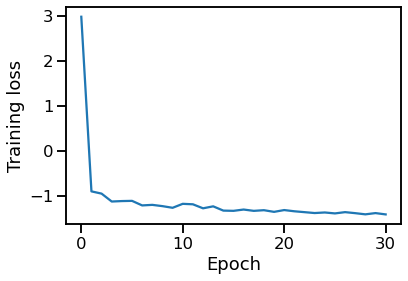

In [16]:
import seaborn as sns
sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("TrainingLoss_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [37]:
# save the results, then apply them with the script apply_pzflow_dc2full.py
flow.save('../data_files/pzflow_dc2small_1hundredth')

In [18]:
allSamples = []
for chunk in data_list:
    samples = flow.sample(1, conditions=chunk, seed=0)
    allSamples.append(samples)
samples=pd.concat(allSamples)

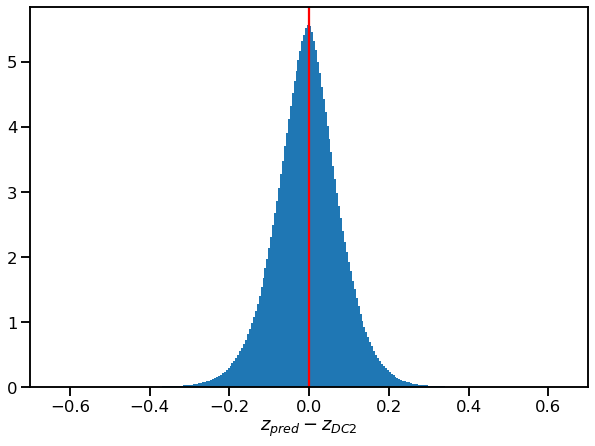

In [40]:
plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values - data['redshift'].values, bins=500, density=True);
plt.axvline(x=0, c='r')
plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred} - z_{DC2}$");
#plt.savefig("zPred_vs_zDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

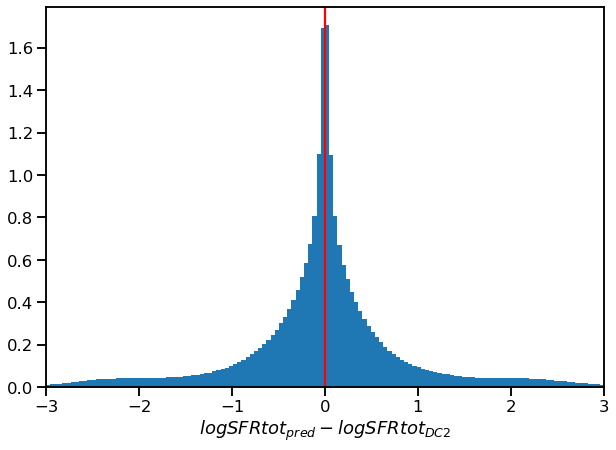

In [39]:
plt.figure(figsize=(10,7))
plt.hist(samples['logSFRtot'].values - data['logSFRtot'].values, bins=500, density=True);
plt.axvline(x=0, c='r')
plt.xlim((-3, 3))
plt.xlabel(r"$logSFRtot_{pred} - logSFRtot_{DC2}$");
#plt.savefig("SFRtotPred_vs_SFRtotDC2_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

In [48]:
# take a subset for plotting
idx = onp.random.choice(np.arange(len(samples)), size=int(len(samples)/10.), replace=False)
pzsamp = samples.iloc[idx]
dc2samp = data.iloc[idx]

Text(0, 0.5, 'logSFRtot')

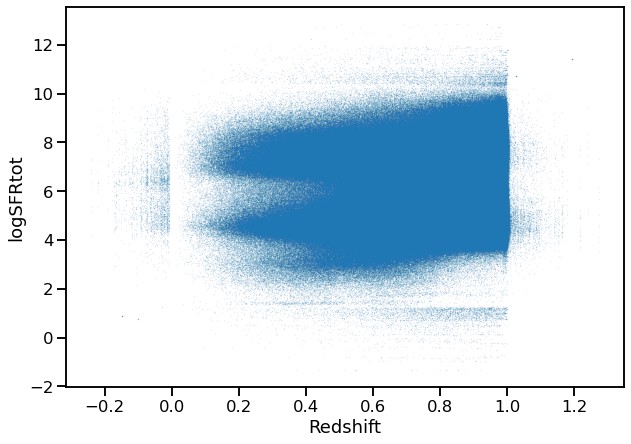

In [50]:
plt.figure(figsize=(10,7))
plt.plot(pzsamp['redshift'], pzsamp['logSFRtot'], 'o', ms=0.08, alpha=.5)
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
#plt.savefig("SFR_vs_Redshift_pzFlowOnly.png",dpi=300, bbox_inches='tight')

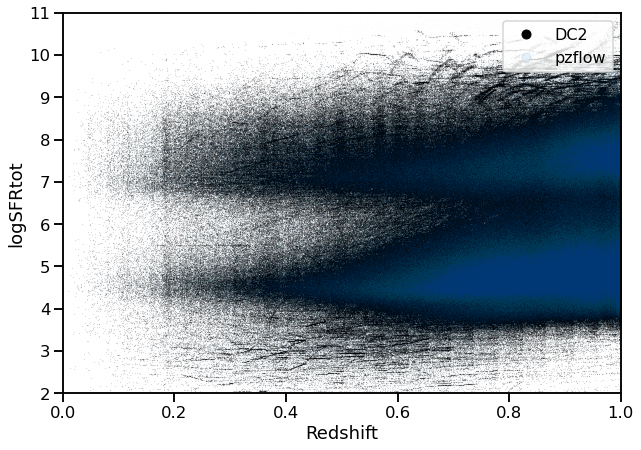

In [51]:

plt.figure(figsize=(10,7))
plt.plot(dc2samp['redshift'], dc2samp['logSFRtot'], 'o', ms=0.05, alpha=1, label='DC2', c='k')
plt.plot(pzsamp['redshift'], pzsamp['logSFRtot'], 'o', ms=0.05, alpha=.1, label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((2, 11.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")

legend = plt.legend(fontsize=16, loc='upper right')
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(9)

#plt.savefig("SFR_vs_Redshift_pzFlow.png",dpi=300, bbox_inches='tight')

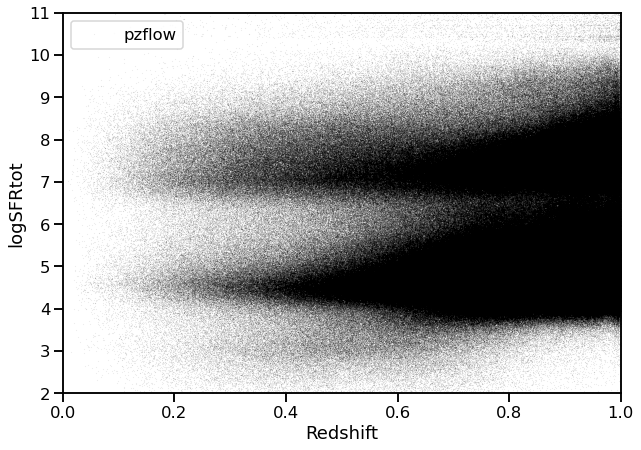

In [57]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(pzsamp['redshift'], pzsamp['logSFRtot'], 'o', ms=0.05, alpha=.5, c='k', label='pzflow')
plt.xlim((0, 1.0))
plt.ylim((2, 11.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(loc='upper left')
#plt.savefig("SFR_vs_Redshift_justPZFlow.png",dpi=300, bbox_inches='tight')

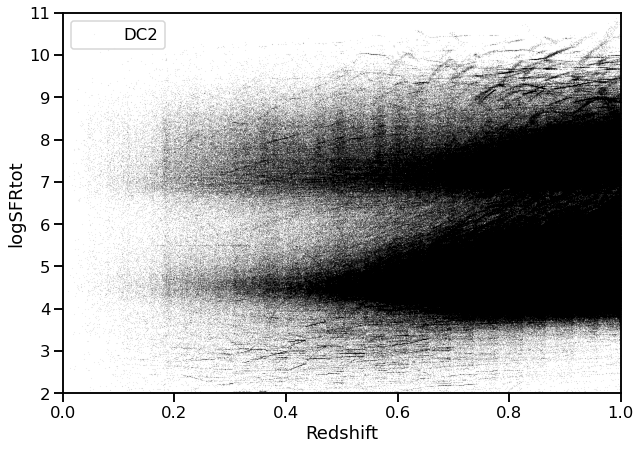

In [56]:
#plot them again, separately 
plt.figure(figsize=(10,7))
plt.plot(dc2samp['redshift'], dc2samp['logSFRtot'], 'o', ms=0.05, alpha=.5, label='DC2', c='k')
plt.xlim((0, 1.0))
plt.ylim((2, 11.0))
plt.xlabel("Redshift")
plt.ylabel("logSFRtot")
plt.legend(loc='upper left')
#plt.savefig("SFR_vs_Redshift_justDC2.png",dpi=300, bbox_inches='tight')

Text(0.5, 0, '$logSFRtot_{pred}$')

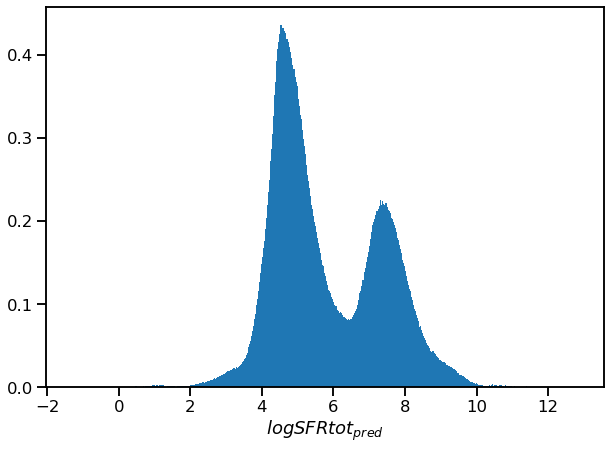

In [58]:
plt.figure(figsize=(10,7))
plt.hist(pzsamp['logSFRtot'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$logSFRtot_{pred}$")
#plt.savefig("SFRtotPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

Text(0.5, 0, '$z_{pred}$')

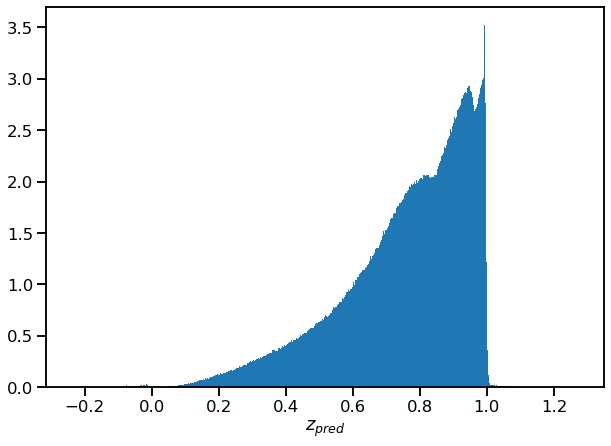

In [59]:
plt.figure(figsize=(10,7))
plt.hist(pzsamp['redshift'].values, bins=500, density=True);
#plt.hist(r, bins=500, density=True, lw=3,fill=False, color='k', histtype='step');
#plt.axvline(x=0, c='r')
#plt.xlim((-0.7, 0.7))
plt.xlabel(r"$z_{pred}$")
#plt.savefig("zPred_conditionalFlow_wSFRtot.png",dpi=300, bbox_inches='tight')

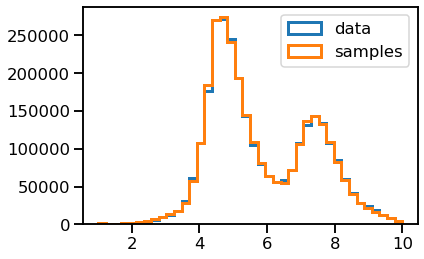

In [62]:
plt.hist(dc2samp['logSFRtot'].values, range=(1, 10),bins=40,  histtype='step', label='data',lw=3)
plt.hist(pzsamp['logSFRtot'].values, range=(1, 10),bins=40,  histtype='step', label='samples',lw=3)
plt.legend()
# plt.savefig("SFR_conditionalSampling.png",dpi=200, bbox_inches='tight')

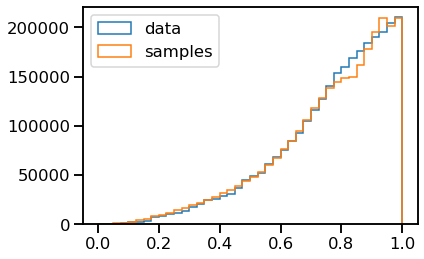

In [64]:
plt.hist(dc2samp['redshift'], range=(0, 1.0), bins=40, histtype='step', label='data')
plt.hist(pzsamp['redshift'], range=(0, 1.0), bins=40, histtype='step', label='samples')
plt.legend(loc='upper left')
# plt.savefig("Histogram_z_allProperties_ConditionalZSFR.png",dpi=200)

In [67]:
pzsamp.columns[0]

'redshift'

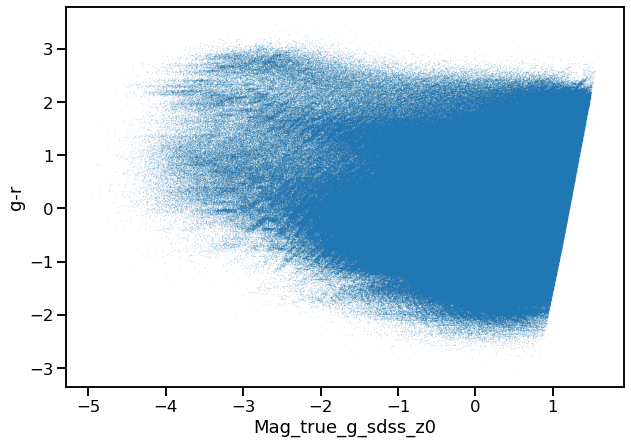

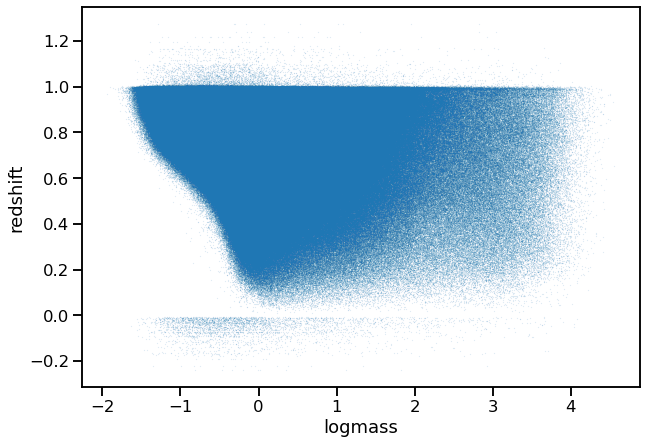

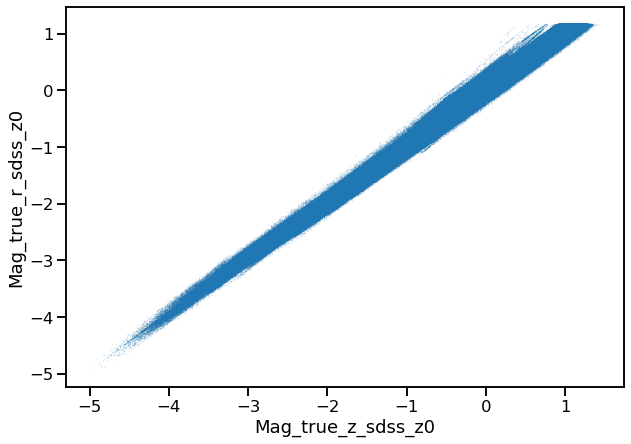

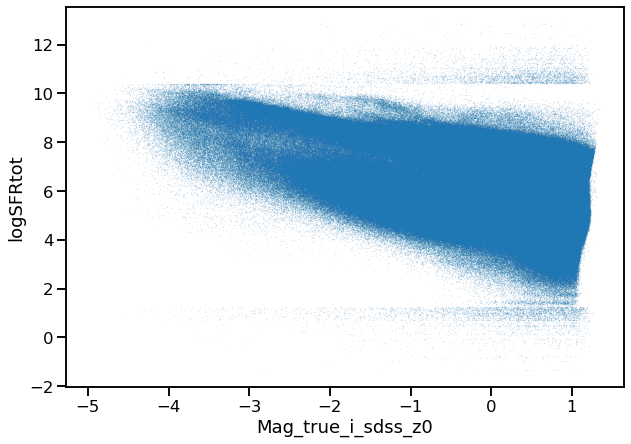

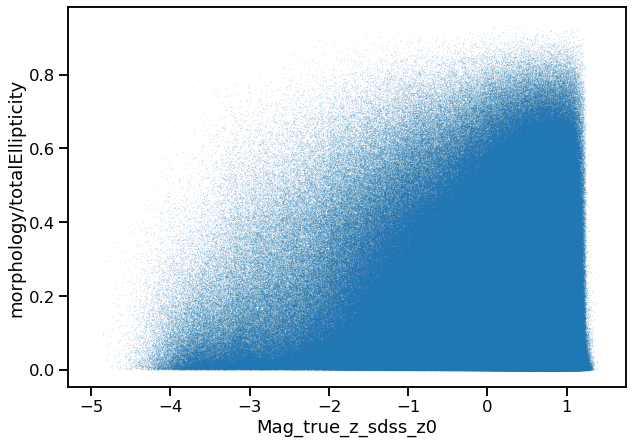

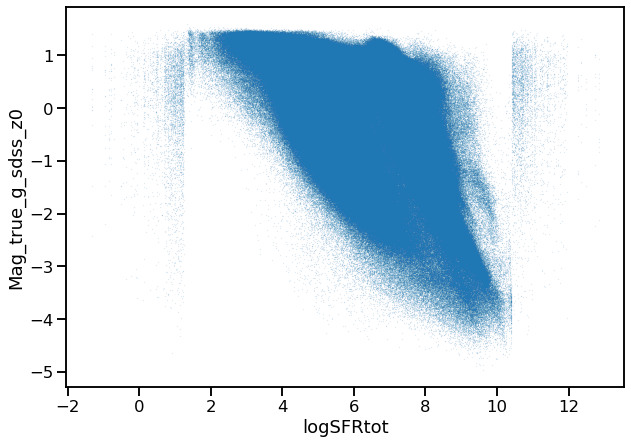

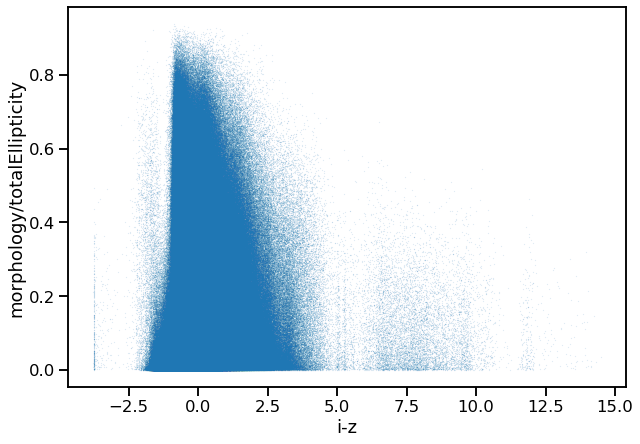

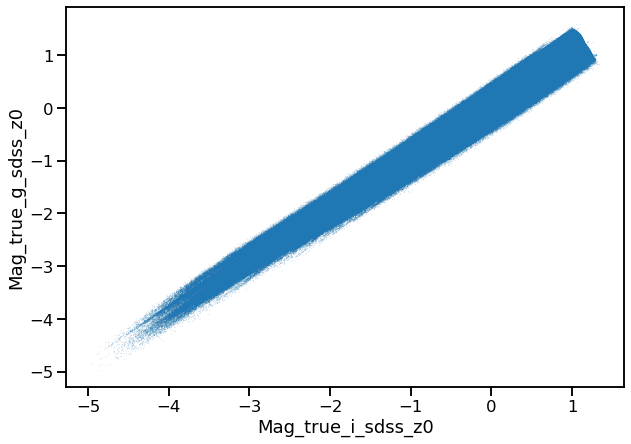

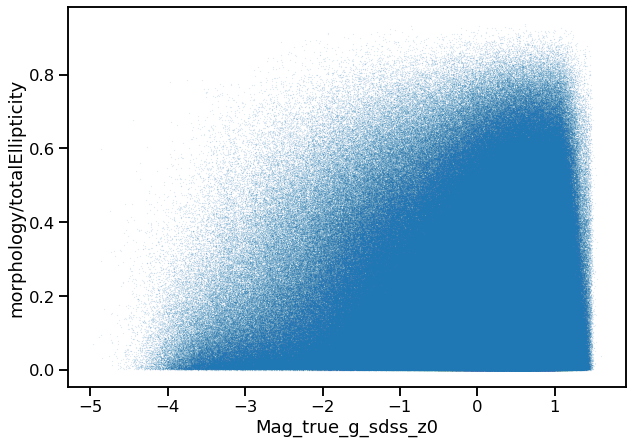

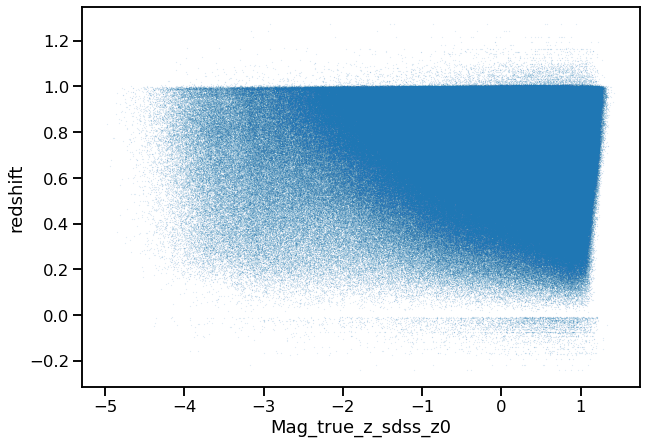

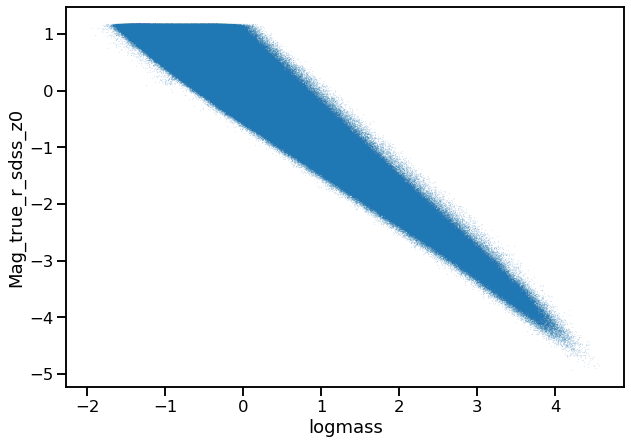

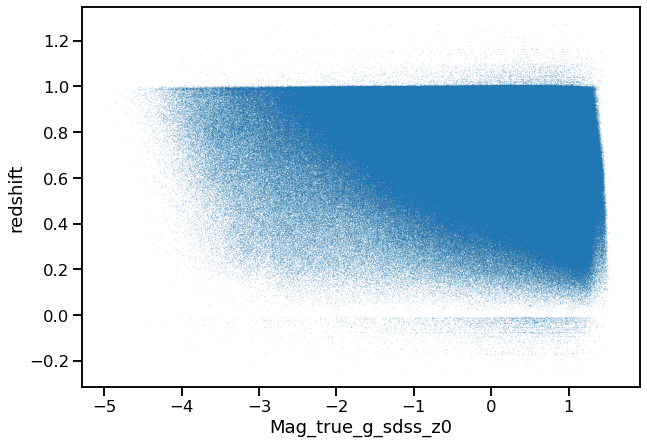

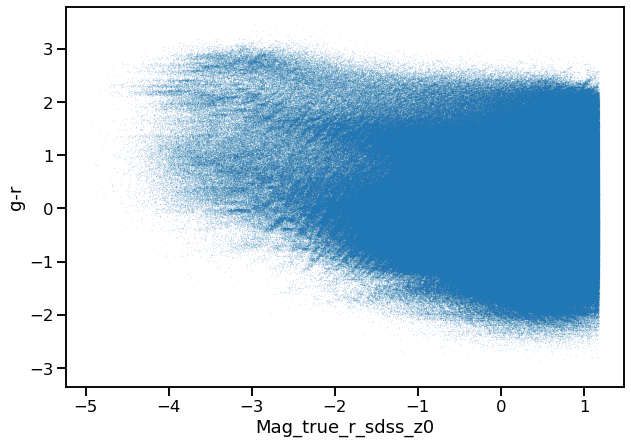

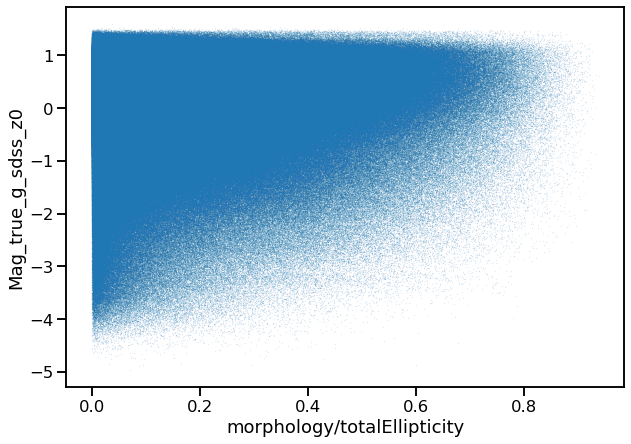

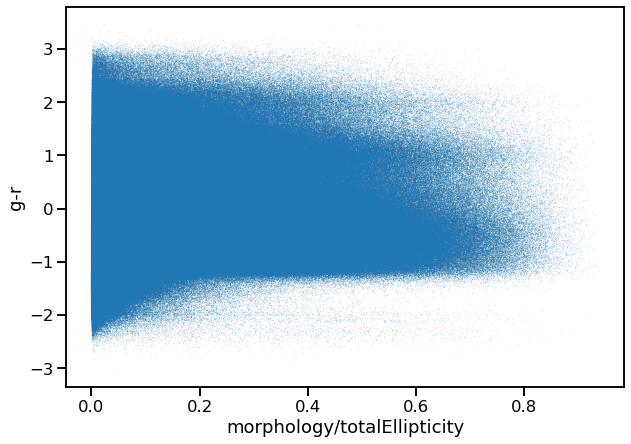

/global/u2/m/mlokken/mydescdev/lib/python3.7/site-packages/pandas/core/generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


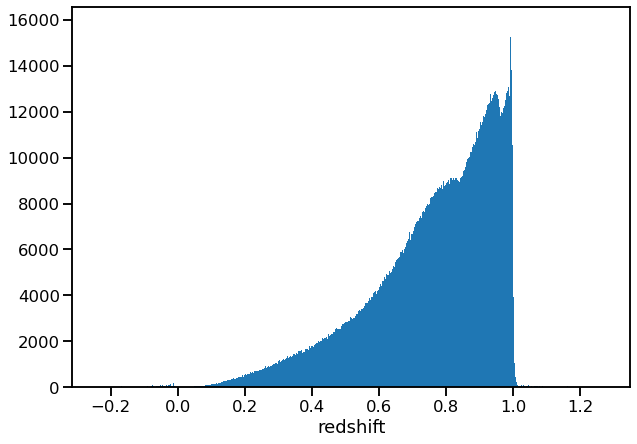

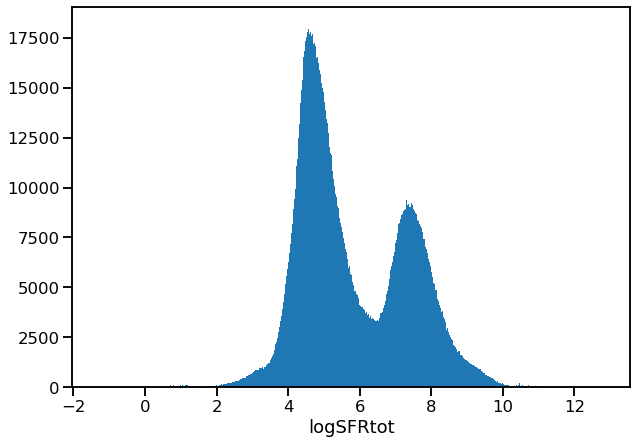

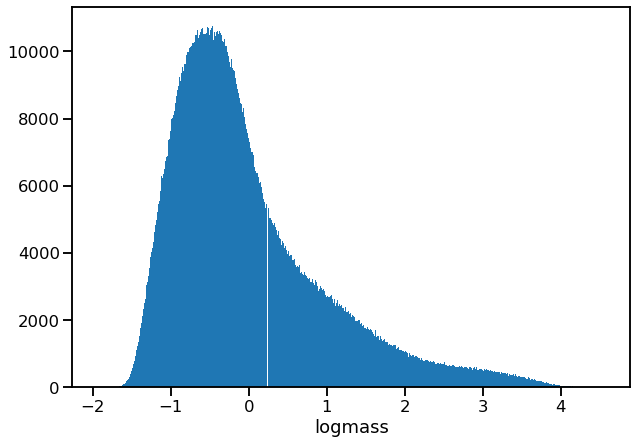

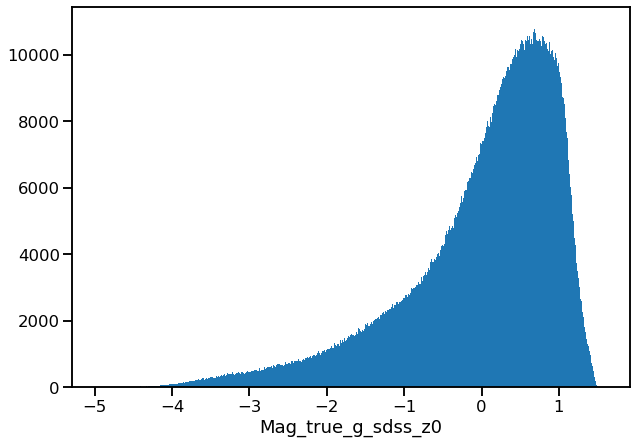

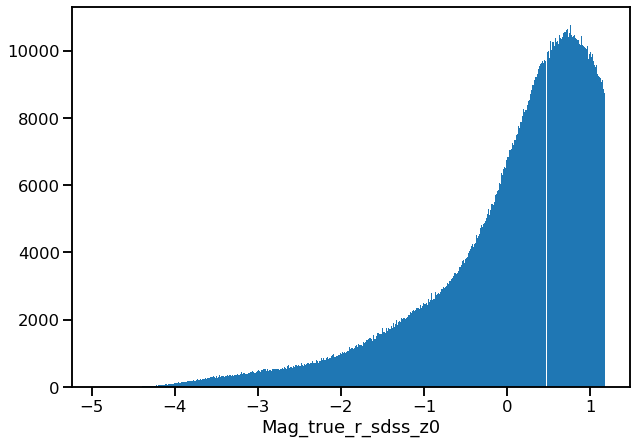

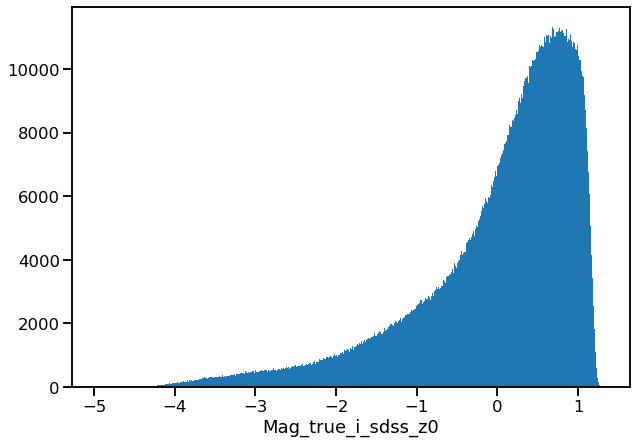

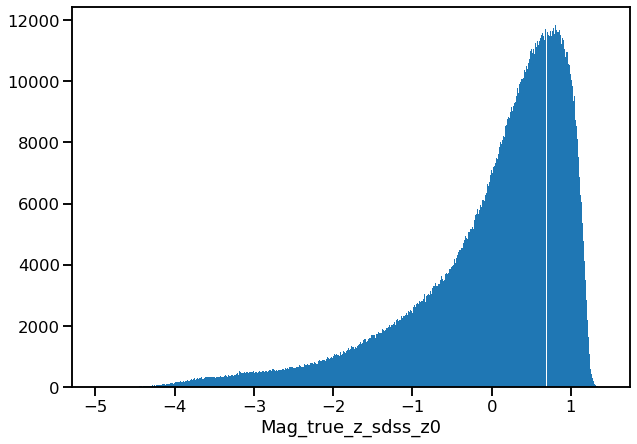

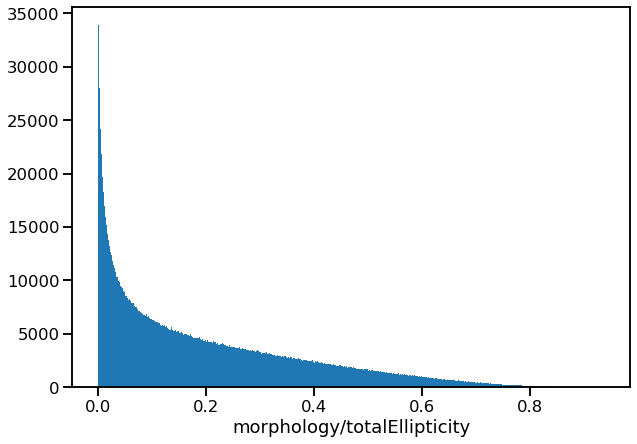

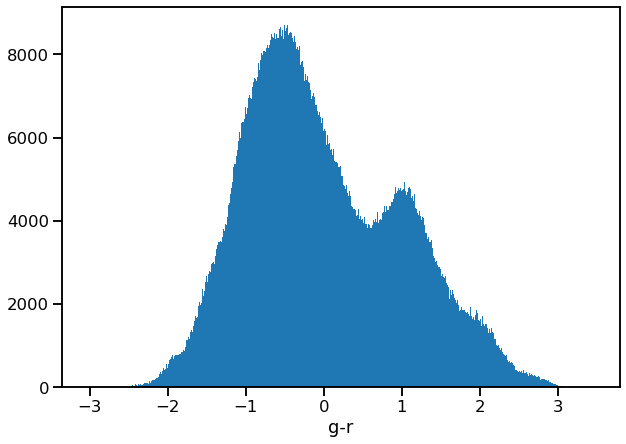

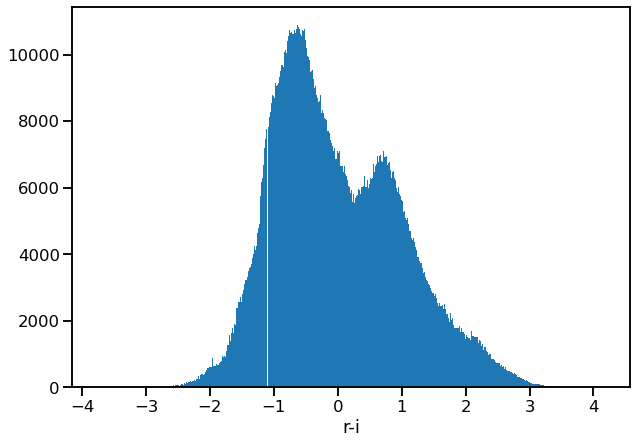

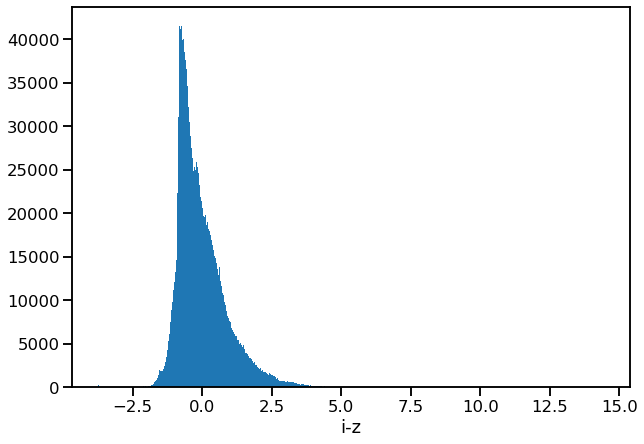

In [68]:
import random

sns.set_context("talk")
params = pzsamp.columns

for i in np.arange(15):
    idx1 = random.randint(0, len(params)-1)
    idx2 = random.randint(0, len(params)-1)
    if idx1 == idx2:
        continue
    plt.figure(figsize=(10,7))
    plt.plot(pzsamp[params[idx1]], pzsamp[params[idx2]],'o',ms=0.05)
    plt.xlabel(params[idx1])
    plt.ylabel(params[idx2])
    plt.show()

for i in np.arange(len(params)):
    vals = pzsamp[params[i]]
    vals.replace([np.inf, -np.inf], np.nan, inplace=True) #drop inf
    vals = vals[vals == vals] #drop na
    plt.figure(figsize=(10,7))
    plt.hist(vals, bins=int(1.e3))
    plt.xlabel(params[i])